# Step 4 Deployment

In this notebook we will be deploying the machine learning model in the `step 3` notebook to `seldon`. After deploying we will send test data to the deployed model, then use the service to predict anomolies on incoming batched data.

## 1. Build a model image using `s2i`

`s2i` is a RedHat supported tool to create docker images from source code. You simply can use the cli provide source code and a base image and out pops a new docker image with your code inside it as well as installed configuration and dependencies

Below we will build 2 containers, autoencoder to help create reconstructed inputs, and an encoder to create a latent space transformation of our model

In [ ]:
%%time
%%bash
s2i build ./deployment/autoencoder seldonio/seldon-core-s2i-python3:0.5.1 autoencoder
s2i build ./deployment/encoder seldonio/seldon-core-s2i-python3:0.5.1 encoder

## 2. Deploying via `kubectl`

Now that we have a docker image build with our model inside, we can now deploy it to our kubernetes cluster via `kubectl` with a seldondeployment yaml file

In [5]:
!cat $HOME/work/yml/autoencoder_deployment.yml

---
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: autoencoder-deployment
spec:
  annotations:
    project_name: autoencoder
    deployment_version: '0.0'
  name: autoencoder-deployment
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: autoencoder:latest
          imagePullPolicy: Never
          name: autoencoder
          resources:
            requests:
              memory: 1Mi
        terminationGracePeriodSeconds: 20
    graph:
      children: []
      name: autoencoder
      endpoint:
        type: REST
      type: MODEL
    name: autoencoder
    replicas: 1
    annotations:
      predictor_version: '0.0'


## 3. Testing a deployed model

Now that we have a model deployed we can test these models using the `SeldonClient`. We can instantiate a few clients for each of our models and create a helper function to return the reconstructino loss and latent space transformation for a useful visualization to find request anomolies

In [13]:
import numpy as np
from seldon_core.seldon_client import SeldonClient

import string
vocabulary = list(string.ascii_lowercase + string.digits + string.punctuation)

sc_autoencoder = SeldonClient(deployment_name="autoencoder-deployment",
                              namespace="default", 
                              ambassador_endpoint="seldon-core-ambassador:80")
sc_encoder = SeldonClient(deployment_name="encoder-deployment",
                          namespace="default", 
                          ambassador_endpoint="seldon-core-ambassador:80")

def get_reconstruction_loss(input_arr):
    shape = input_arr.shape
    response = sc_autoencoder.predict(gateway="ambassador",
                                      transport="rest", 
                                      data=input_arr)
    response_arr = np.array(response.response.data.tensor.values).astype(int).reshape(shape)
    return ((input_arr - response_arr)**2).mean()

def get_latent_transformation(input_arr):
    shape = input_arr.shape
    response = sc_encoder.predict(gateway="ambassador",
                                  transport="rest", 
                                  data=input_arr)
    return np.array(response.response.data.tensor.values)

#### Test reconstruction

In [45]:
data = np.random.randint(100, size=(1,68))
data

array([[29, 57, 60, 68, 37, 95,  0, 79, 36, 99, 19, 52,  1, 28, 64, 92,
        50, 57, 49, 40, 59, 66, 22, 53, 52, 46, 71, 68, 62, 71, 95, 83,
        23, 10,  9, 31, 40,  7, 40, 39, 32, 38, 96, 61,  2, 23, 36, 50,
        72,  3, 62, 61, 86, 47, 41,  4, 63, 55, 32, 37, 43, 28, 47,  8,
        92,  8, 13, 11]])

In [46]:
get_reconstruction_loss(data)

2392.25

In [47]:
get_latent_transformation(data)

array([71.29456329, 24.51876068])

# Building a anomoly monitoring dashboard

Now that we have our autoencoder and encoder services deployed we can build a monitoring dashboard in `holoviews` with `bokeh` streaming batched data from `minio` to show when we are recieving normal data and when we are seeing anomolous data.

We expect to see the attackers data percieved as anomolies in this system.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
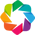

In [17]:
import json
import string
import urllib
from urllib.parse import unquote
from datetime import datetime

import minio
from minio import Minio
from minio.error import ResponseError

import re
import numpy as np
import pandas as pd

from holoviews import opts
import holoviews as hv
hv.extension("bokeh")

from holoviews.streams import Pipe, Buffer
from streamz import Stream
from functools import partial

import warnings
warnings.filterwarnings("ignore")

## Create minio client

Using the minio client we can listen for notifications for changes on a particular bucket. We can listen to when an object has been added to a bucket, and use that event to trigger an update to the dashboard to call the model services and update the respective plots

In [54]:
minioClient = Minio('anacondacon2019-minio:9000',
                    access_key='anacondacon2019',
                    secret_key='anacondacon2019',
                    secure=False)

In [63]:
## Remove objects
objects = [i for i in list(minioClient.list_objects('data'))]
removals = [minioClient.remove_object('data',obj.object_name) for obj in objects]

## Data preperation

In [19]:
import re
import pandas as pd

import string
import numpy as np
from collections import Counter

## Global vocabulary of characters
vocabulary = list(string.ascii_lowercase + string.digits + string.punctuation)

def frequency_array(iter_input, vocabulary=vocabulary):
    """ Turn a string into frequency count np.array
    """
    freq = Counter(iter_input)
    return np.array([freq[v] for v in vocabulary]) 

def transform(input_df):
    
    input_df["parsed"] = (input_df.content
                                  .str
                                  .lower()
                                  .apply(lambda i:str(re.sub(r"^\w",'',i))))
    
    df_vocab = pd.DataFrame(columns=vocabulary, 
                            data=np.stack(input_df['parsed'].apply(frequency_array)))
    df_vocab.index = pd.DatetimeIndex(input_df['time'])

    return input_df, df_vocab

## Creating the event stream

To create an updating dashboard in `holoviews` you first create a event `Stream` in the library `streamz`. After defining the appropriate transformations from the `Stream` you then place that objects source reference into the `streams` argument of a `holoviews.DynamicMap` object. 

On every `emit` event into the `Stream` the `holoviews.DynamicMap` will update it's javascript representation in the browser showing the latest changes of the data in its visual representation.

In [48]:
## Create stream resources
source = Stream()
source_vocab = Stream()

example = pd.DataFrame(dict(reconstruction_loss=[], file_data=[]), index=pd.DatetimeIndex([],name='time'))
pipe_reconstruction = Pipe(data=example)
example = pd.DataFrame(dict(latent_x=[0],latent_y=[0]), index=pd.DatetimeIndex([0],name='time'))
pipe_latent = Pipe(data=example)

## Building the anomoly detection pipeline

Using the `streamz` library we will intake the reconstruction loss and content dataframes to output request data that exceeds the reconstruction loss

In [ ]:
def detect_anomolies(input_tuple_df, threshold=5):
    '''Return anomolies from reconstruction dataframe and file data'''
    reconstruction_df, content_df = input_tuple_df
    merged_df = reconstruction_df.merge(content_df.set_index('time'),
                                        how='inner', 
                                        left_index=True, 
                                        right_index=True)
    merged_df = merged_df.loc[merged_df['reconstruction_loss'] > threshold]
    merged_df['file_data'] = merged_df['content'].apply(lambda i:unquote(json.loads(i)['http.file_data']))
    return merged_df[['reconstruction_loss','file_data']]

## Define reconstruction loss stream
source_reconstruction_loss = \
    (source_vocab.map(
        lambda df:df.assign(
            reconstruction_loss=df.apply(
                lambda row:get_reconstruction_loss(row.values.reshape((1,68))), axis=1))))

## Pipeline of merged information
source_reconstruction_loss_all = \
    (source_reconstruction_loss.zip(source)
                               .map(detect_anomolies)
                               .accumulate(func=lambda state,new:pd.concat([state,new]), 
                                           returns_state=False, 
                                           start=pd.DataFrame(columns=["reconstruction_loss", "file_data"], 
                                                              index=pd.DatetimeIndex([],name='time'))))

## Define aggregated loss dataframe with pipe sink
(source_reconstruction_loss.zip(source)
                           .map(lambda df:detect_anomolies(df,threshold=0))
                           .map(lambda df:df[['reconstruction_loss','file_data']])
                           .accumulate(func=lambda state,new:pd.concat([state,new]), 
                                       returns_state=False, 
                                       start=pd.DataFrame(columns=["reconstruction_loss", "file_data"], 
                                                          index=pd.DatetimeIndex([],name='time')))
                           .map(lambda df:df.reset_index())
                           .sink(pipe_reconstruction.send))

## Building the latent transformation pipeline

Using the `streamz` library we will intake the latent space transformations and output the latent features for plotting

In [ ]:
## Define latent transformation strea,
def latent_transformation_coords(input_df):
    latent_transformation_df = input_df.apply(lambda row:get_latent_transformation(row.values.reshape((1,68))),axis=1)
    return_df = pd.DataFrame(latent_transformation_df.values.tolist(), 
                             columns=['latent_x','latent_y'],
                             index=input_df.index)
    return return_df
source_latent_transformation = source_vocab.map(lambda df:latent_transformation_coords(df))

## Define aggregated latent transformation dataframe with pipe sink
(source_latent_transformation.accumulate(func=lambda state,new:pd.concat([state,new]), 
                                         returns_state=False, 
                                         start=pd.DataFrame(columns=['latent_x','latent_y'], 
                                                            index=pd.DatetimeIndex([],name='time')))
                             .sink(pipe_latent.send))

## Visualization

Now using `holoviews` we can compose multiple visualization ontop of eachother to create an dashboard which will provide us up to date feedback from the driving for loop below  

In [ ]:
%%opts Scatter [width=400 height=400 tools=["hover"]] (size=4)                  {+framewise}
%%opts Curve   [width=580 height=400 tools=["hover"], xrotation=45 ylim=(0,15)] {+framewise}

((hv.DynamicMap(hv.Curve, streams=[pipe_reconstruction]) *\
  hv.HLine(7))
    .opts(opts.HLine(color='blue', line_width=3))) +\
hv.DynamicMap(partial(hv.Scatter, 
                      kdims=['latent_x'], 
                      vdims=['latent_y']), 
              streams=[pipe_latent])

In [43]:
source_reconstruction_loss_all

Output()

## Event driven dashboard

Now with the visualization rendered in this notebook we can listen to notifications to a minio bucket for updates to the object storage and push that event data to our dashboard to keep it updated with the latest data.

In [44]:
for event in minioClient.listen_bucket_notification('data',events=['s3:ObjectCreated:*']):
    object = urllib.parse.unquote(event["Records"][0]['s3']["object"]["key"])
    try:
        print("Piping data from: ", object)
        data = str(minioClient.get_object('data', object).data.decode('utf-8'))
        df = pd.read_csv(pd.compat.StringIO(data), sep=',')
        df, df_vocab = transform(df)
        source.emit(df)
        source_vocab.emit(df_vocab)
    except ResponseError as err:
        print(err)

data-2019-04-05_05:37:35.csv
data-2019-04-05_05:37:39.csv
data-2019-04-05_05:37:44.csv
data-2019-04-05_05:37:49.csv
data-2019-04-05_05:37:54.csv
data-2019-04-05_05:38:00.csv
data-2019-04-05_05:38:03.csv
data-2019-04-05_05:38:06.csv
data-2019-04-05_05:38:12.csv
data-2019-04-05_05:38:18.csv
data-2019-04-05_05:38:22.csv
data-2019-04-05_05:38:28.csv
data-2019-04-05_05:38:36.csv
data-2019-04-05_05:38:42.csv
data-2019-04-05_05:38:48.csv
data-2019-04-05_05:38:52.csv
data-2019-04-05_05:38:57.csv
data-2019-04-05_05:38:59.csv
data-2019-04-05_05:39:03.csv
data-2019-04-05_05:39:07.csv
data-2019-04-05_05:39:13.csv
data-2019-04-05_05:39:18.csv
data-2019-04-05_05:39:31.csv
data-2019-04-05_05:39:41.csv
data-2019-04-05_05:39:47.csv
data-2019-04-05_05:39:48.csv
data-2019-04-05_05:39:50.csv
data-2019-04-05_05:39:56.csv
data-2019-04-05_05:40:00.csv
data-2019-04-05_05:40:04.csv
data-2019-04-05_05:40:08.csv


KeyboardInterrupt: 